In [57]:
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import scipy.cluster.hierarchy as sch

In [58]:
data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Wholesale customers data.csv")
print(data.head())
print(data.info())

   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen  

In [59]:
data.drop(['Region', 'Channel'], axis = 1, inplace = True)
print('    checking null values   ')
print(data.isna().sum())

    checking null values   
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [60]:
##PCA
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)


In [61]:
def cluster_results(reduced_data, preds, centers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions
    Adds cues for cluster centers and student-selected sample data
    '''

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                 color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

   # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

# Plot transformed sample points 
    ax.scatter(x = pca_samples[:,0], y = pca_samples[:,1], \
             s = 150, linewidth = 4, color = 'black', marker = 'x');

# Set plot title
    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");

In [62]:
def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names
    reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

In [63]:
def channel_results(reduced_data, outliers, pca_samples):
    '''
    Visualizes the PCA-reduced cluster data in two dimensions using the full dataset
    Data is labeled by "Channel" and cues added for student-selected sample data
    '''
    full_data = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Wholesale customers data.csv")

# Create the Channel DataFrame
    channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
    channel = channel.drop(channel.index[outliers]).reset_index(drop = True)
    labeled = pd.concat([reduced_data, channel], axis = 1)
  
    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned Channel
    labels = ['Hotel/Restaurant/Cafe', 'Retailer']
    grouped = labeled.groupby('Channel')
    for i, channel in grouped:   
        channel.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                    color = cmap((i-1)*1.0/2), label = labels[i-1], s=30);
        
    # Plot transformed sample points   
    for i, sample in enumerate(pca_samples):
        ax.scatter(x = sample[0], y = sample[1], \
              s = 200, linewidth = 3, color = 'black', marker = 'o', facecolors = 'none');
        ax.scatter(x = sample[0]+0.25, y = sample[1]+0.3, marker='$%d$'%(i), alpha = 1, s=125);

# Set plot title
    ax.set_title("PCA-Reduced Data Labeled by 'Channel'\nTransformed Sample Data Circled");

In [64]:
display(data.head())

display(data.describe())
# Select three indices of your choice you wish to sample from the dataset
np.random.seed(2018)
indices = np.random.randint(low = 0, high = 441, size = 3)
print("Indices of Samples => {}".format(indices))

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("\nChosen samples of wholesale customers dataset:")
display(samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Indices of Samples => [250 102 226]

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,3191,1993,1799,1730,234,710
1,2932,6459,7677,2561,4573,1386
2,20782,5921,9212,1759,2568,1553


In [65]:
def predict_one_feature(dropped_feature):
    # Make a copy of the DataFrame, using the 'drop' function to drop the given feature
    print("Dropping feature -> {}".format(dropped_feature))
    new_data = data.drop([dropped_feature], axis = 1)
    
    # Split the data into training and testing sets(0.25) using the given feature as the target
    # Set a random state.
    X_train, X_test, y_train, y_test = train_test_split(new_data, data[dropped_feature], test_size=0.25, random_state=0)
    
    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)
    
    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print("Score for predicting '{}' using other features = {:.3f}\n".format(dropped_feature, score))
    # Attempt to predict the score of 'Milk' using other features
predict_one_feature('Milk')
print("Features in data -> {}\n".format(data.columns.values))

Dropping feature -> Milk
Score for predicting 'Milk' using other features = 0.366

Features in data -> ['Fresh' 'Milk' 'Grocery' 'Frozen' 'Detergents_Paper' 'Delicassen']



Dropping feature -> Fresh
Score for predicting 'Fresh' using other features = -0.252

Dropping feature -> Milk
Score for predicting 'Milk' using other features = 0.366

Dropping feature -> Grocery
Score for predicting 'Grocery' using other features = 0.603

Dropping feature -> Frozen
Score for predicting 'Frozen' using other features = 0.254

Dropping feature -> Detergents_Paper
Score for predicting 'Detergents_Paper' using other features = 0.729

Dropping feature -> Delicassen
Score for predicting 'Delicassen' using other features = -11.664



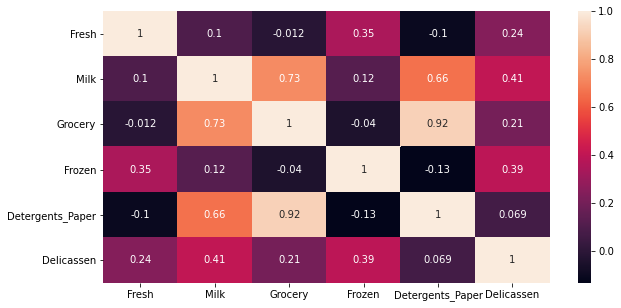

In [66]:
for cols in data.columns.values:
    predict_one_feature(cols)
    # Display the correlation heatmap
corr = data.corr()

plt.figure(figsize = (10,5))
ax = sns.heatmap(corr, annot=True)

No handles with labels found to put in legend.


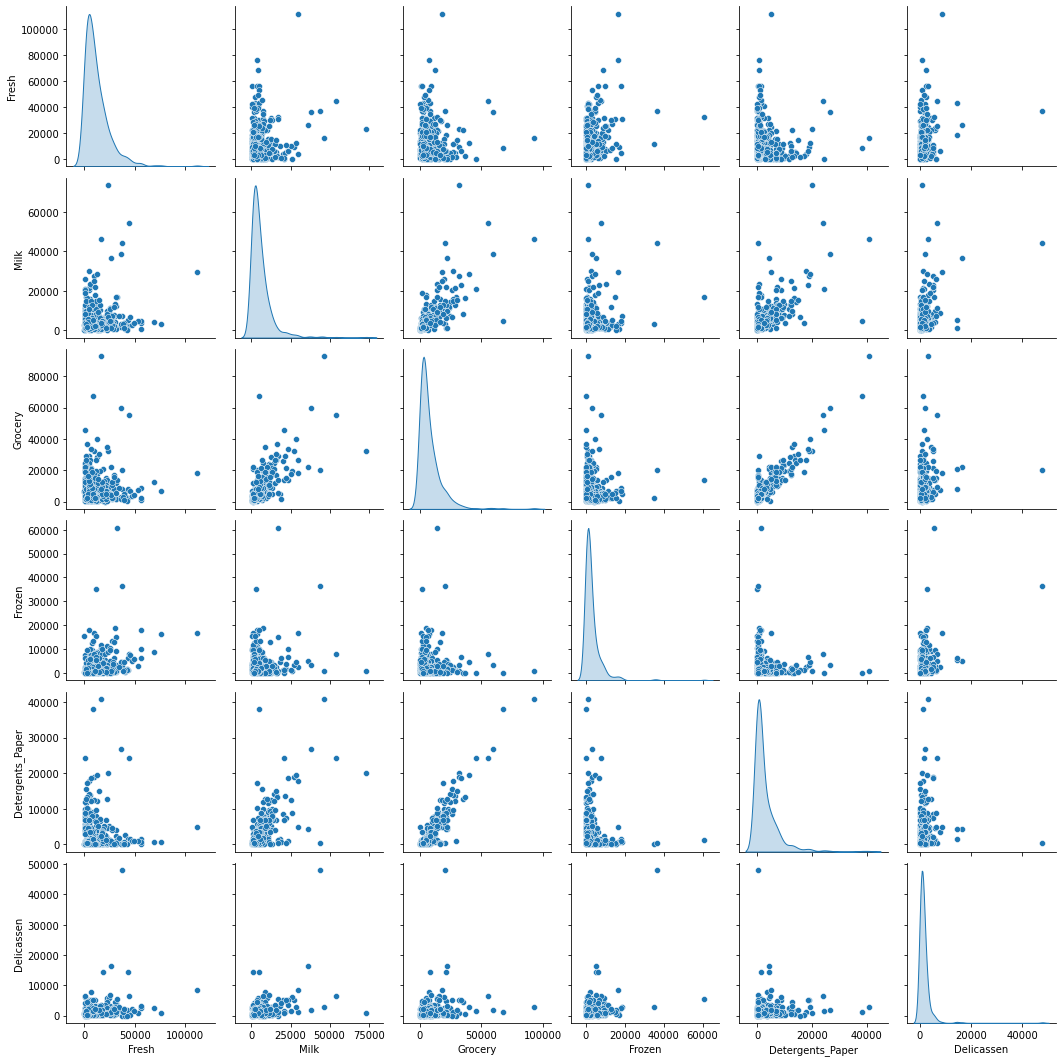

In [67]:
ax.legend(loc=0, prop={'size': 15})
# Produce a scatter matrix for each pair of features in the data
_= sns.pairplot(data, diag_kind = 'kde')

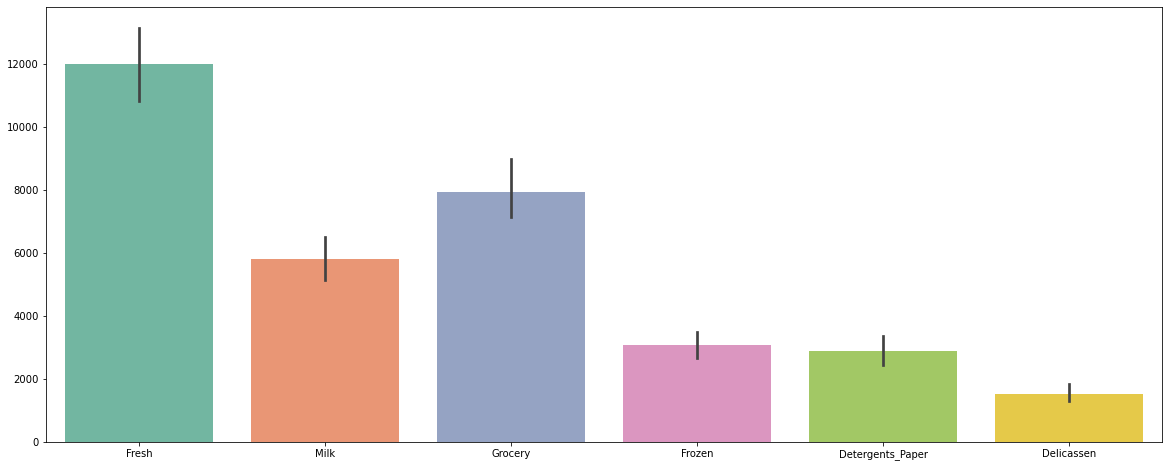

In [68]:
plt.figure(figsize = (20,8))
_ = sns.barplot(data=data, palette="Set2")

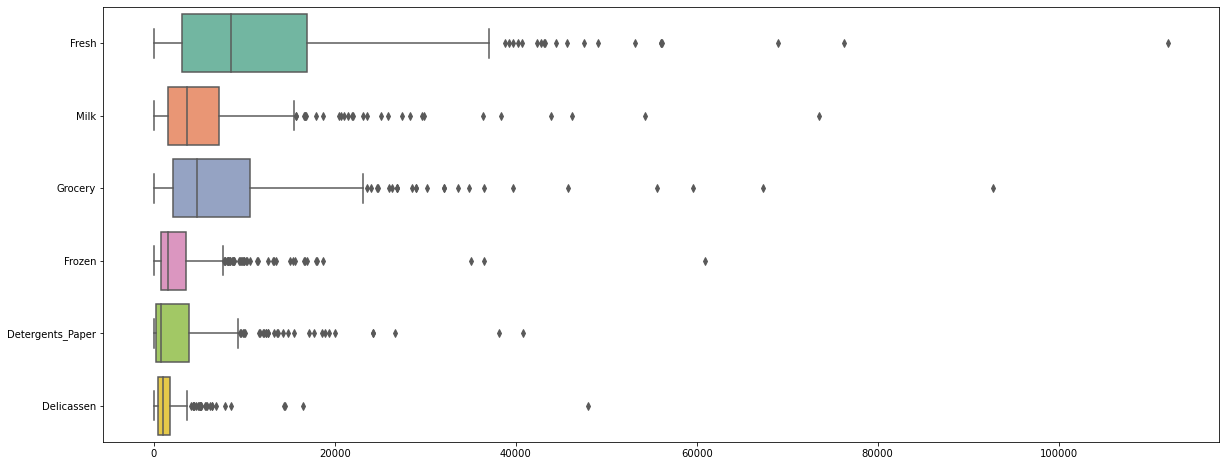

In [69]:
plt.figure(figsize = (20,8))
_ = sns.boxplot(data=data, orient='h', palette="Set2")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


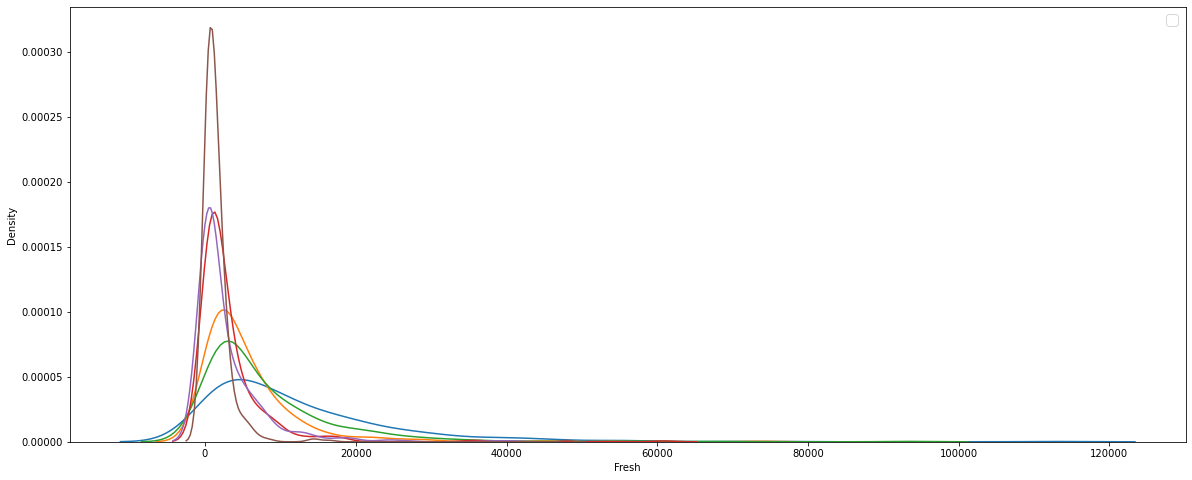

In [70]:
plt.figure(figsize = (20,8))

for cols in data.columns.values:
    ax = sns.kdeplot(data[cols])
    ax.legend(loc=0, prop={'size': 15})
    # Scale the data using the natural logarithm
log_data = np.log(data)


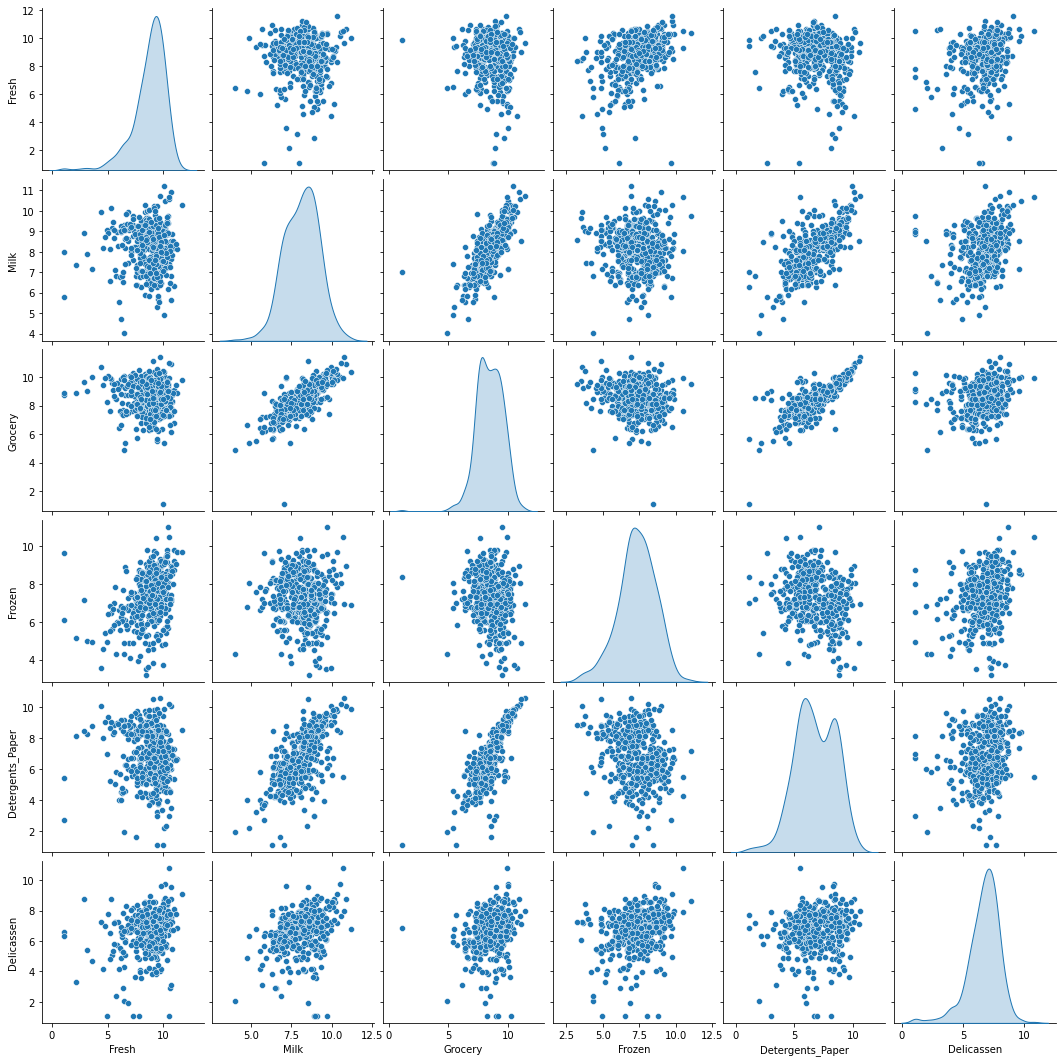

In [71]:
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features ,Normalised data
_ = sns.pairplot(log_data, diag_kind = 'kde')

In [72]:
# Display the log-transformed sample data
display(log_samples)
# Display the correlation heatmap
log_corr = log_data.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,8.068090,7.597396,7.494986,7.455877,5.455321,6.565265
1,7.983440,8.773230,8.945984,7.848153,8.427925,7.234177
2,9.941843,8.686261,9.128262,7.472501,7.850883,7.347944


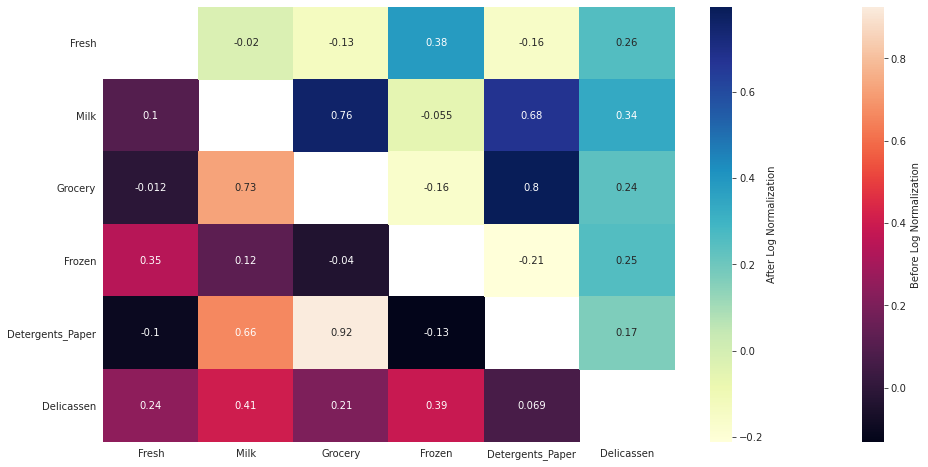

In [73]:
f = plt.figure(figsize = (16,8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(corr, annot=True, mask=mask, cbar_kws={'label': 'Before Log Normalization'})

mask2 = np.zeros_like(corr)
mask2[np.tril_indices_from(mask2)] = True
with sns.axes_style("white"):
    ax2 = sns.heatmap(log_corr, annot=True, mask=mask2, cmap="YlGnBu", cbar_kws={'label': 'After Log Normalization'})
    # boxplot on the logdata

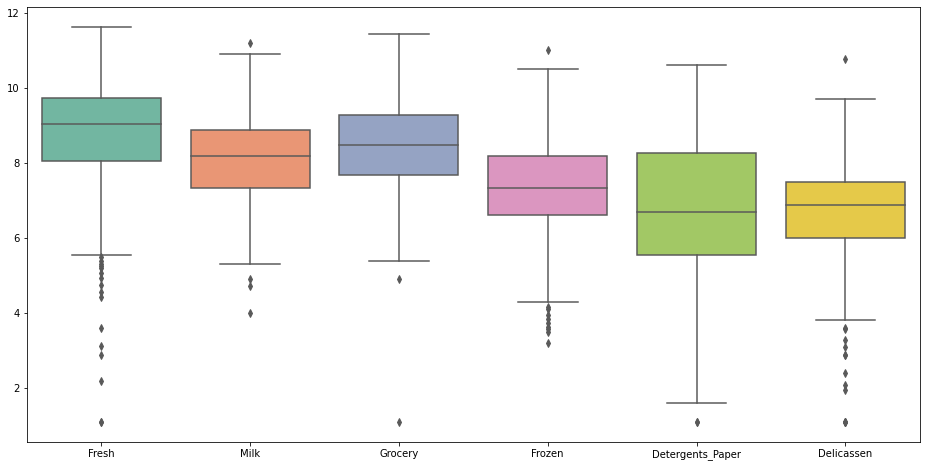

In [74]:
plt.figure(figsize = (16,8))
_ = sns.boxplot(data=log_data, palette="Set2")

In [75]:
outliers_list = []
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    outliers = list(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.values)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    outliers_list.extend(outliers)
    
print("List of Outliers -> {}".format(outliers_list))
duplicate_outliers_list = list(set([x for x in outliers_list if outliers_list.count(x) >= 2]))
duplicate_outliers_list.sort()
print("\nList of Common Outliers -> {}".format(duplicate_outliers_list))

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicassen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


List of Outliers -> [65, 66, 81, 95, 96, 128, 171, 193, 218, 304, 305, 338, 353, 355, 357, 412, 86, 98, 154, 356, 75, 154, 38, 57, 65, 145, 175, 264, 325, 420, 429, 439, 75, 161, 66, 109, 128, 137, 142, 154, 183, 184, 187, 203, 233, 285, 289, 343]

List of Common Outliers -> [65, 66, 75, 128, 154]


Explained Variance Ratio => [0.44302505 0.26379218 0.1230638  0.10120908 0.04850196 0.02040793]

Explained Variance Ratio(csum) => [0.44302505 0.70681723 0.82988103 0.93109011 0.97959207 1.        ]



,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.5715,0.6914,0.7154,-0.0264,0.0495,-0.2803
1,-1.8145,-0.2029,0.7064,0.6552,-0.4010,-0.2483
2,-1.1818,-1.3883,-0.5519,-0.2136,-0.0931,0.1051


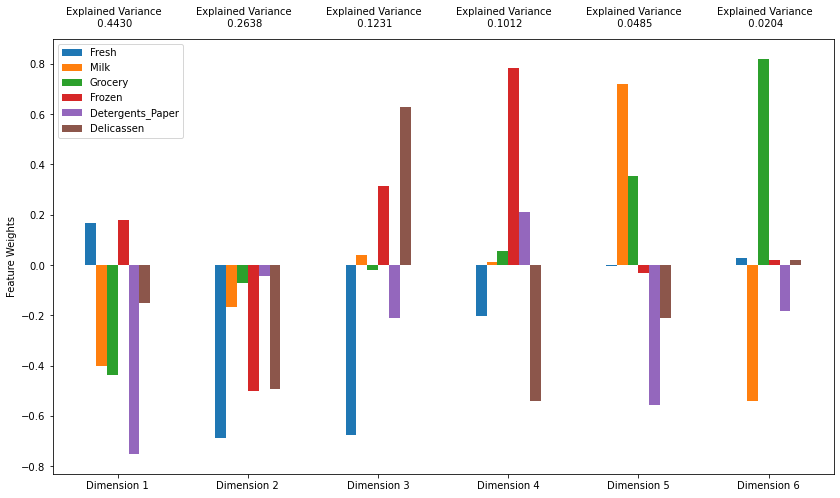

In [76]:

outliers  = duplicate_outliers_list

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components = 6, random_state=0)
pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)
print("Explained Variance Ratio => {}\n".format(pca.explained_variance_ratio_))
print("Explained Variance Ratio(csum) => {}\n".format(pca.explained_variance_ratio_.cumsum()))

# Generate PCA results plot
pca_results = pca_results(good_data, pca)
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components = 2, random_state=0)
pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)




,Dimension 1,Dimension 2
0,1.5715,0.6914
1,-1.8145,-0.2029
2,-1.1818,-1.3883


<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

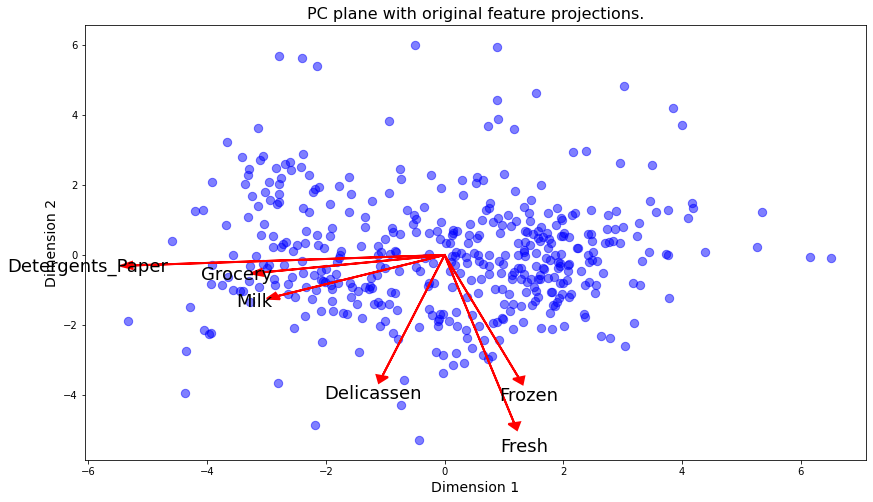

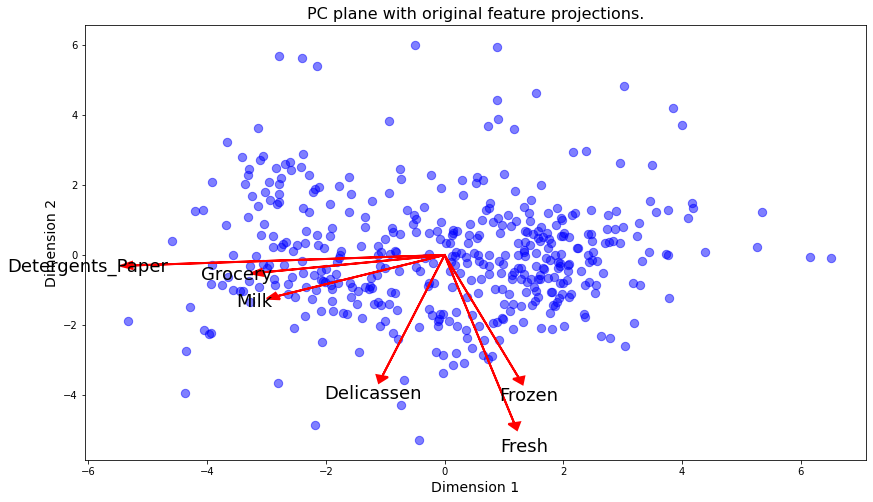

In [77]:
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))
# Create a biplot
biplot(good_data, reduced_data, pca)
# Create a biplot
biplot(good_data, reduced_data, pca)
# Display the results of the clustering from implementation for 3 clusters

<AxesSubplot:title={'center':'PC plane with original feature projections.'}, xlabel='Dimension 1', ylabel='Dimension 2'>

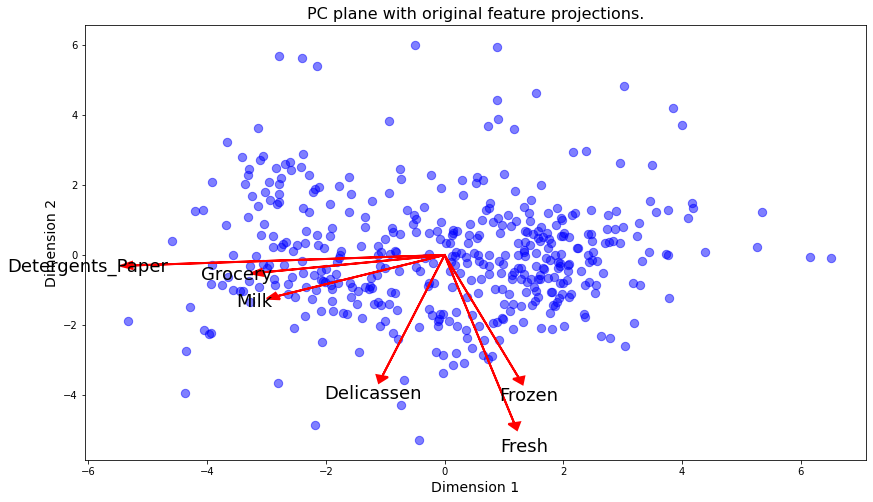

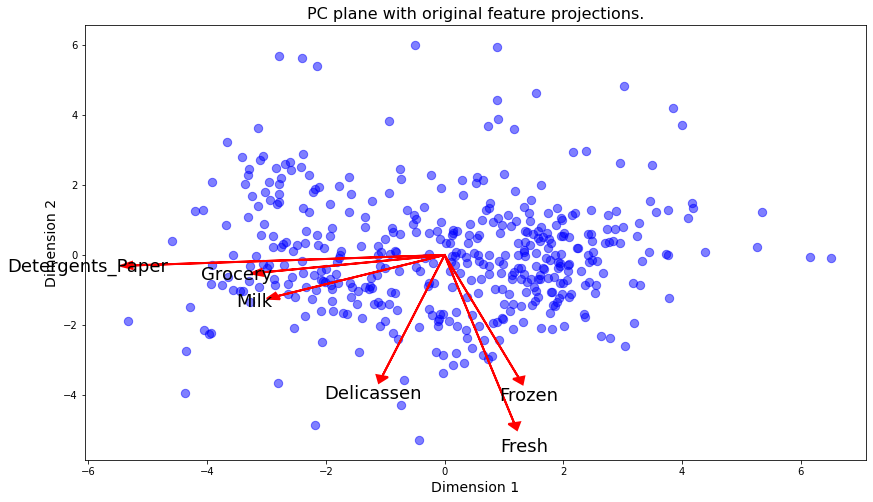

In [36]:

# Create a biplot
biplot(good_data, reduced_data, pca)
# Create a biplot
biplot(good_data, reduced_data, pca)
# Display the results of the clustering from implementation for 3 clusters

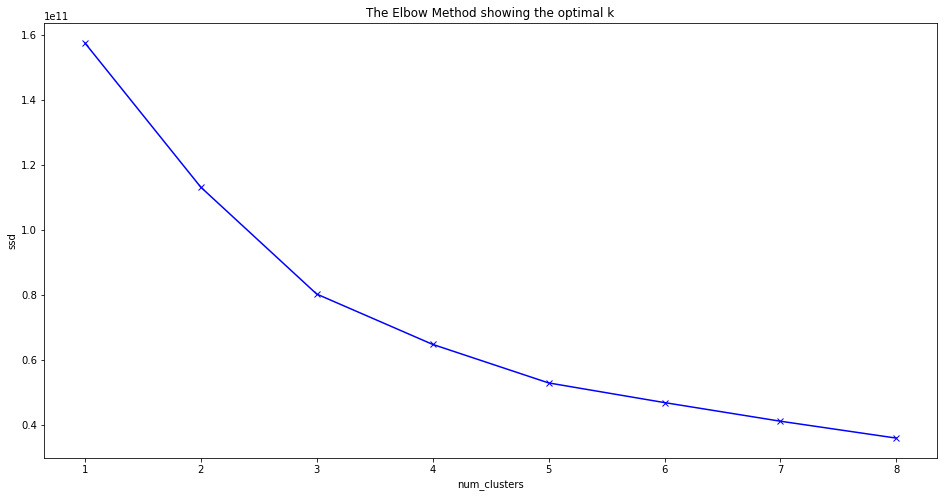

In [80]:
#ELBOW DIAGRAM
ssd = []
range_n_clusters = [1,2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.figure(figsize=(16,8))# ssd
plt.xlabel('num_clusters')
plt.ylabel('ssd')
plt.title('The Elbow Method showing the optimal k')
plt.plot(range_n_clusters,ssd,'bx-')
plt.show()

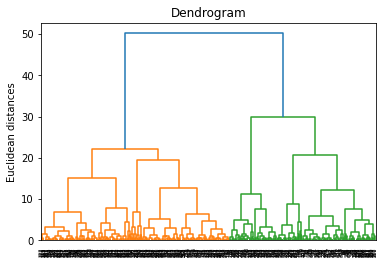

In [82]:
dendrogram = sch.dendrogram(sch.linkage(reduced_data, method  = "ward"))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.show()

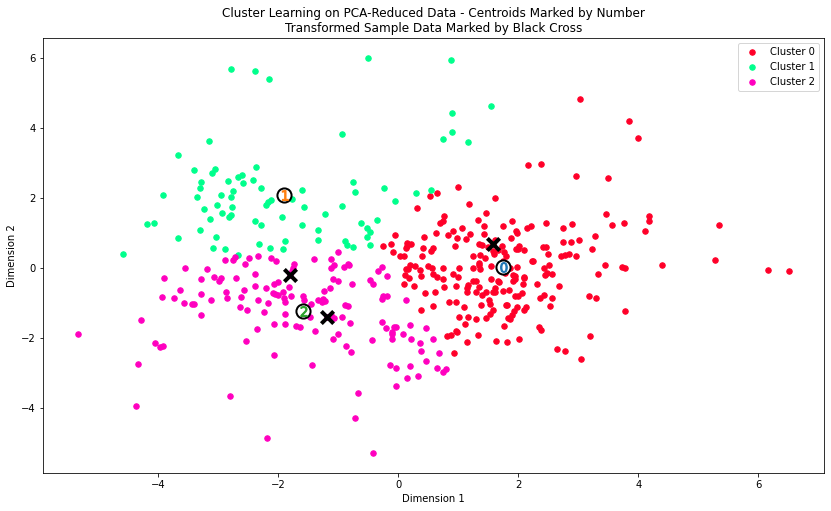

In [84]:
clusterer = KMeans(n_clusters = 3)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
sample_preds = clusterer.predict(pca_samples)

cluster_results(reduced_data, preds, centers, pca_samples)


In [85]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)
display(data.mean(axis=0))
display(samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,8356.0,1671.0,2194.0,2028.0,241.0,610.0
Segment 1,1107.0,5135.0,9395.0,378.0,3442.0,382.0
Segment 2,11484.0,7892.0,10346.0,2122.0,3123.0,1889.0


Fresh               12000.297727
Milk                 5796.265909
Grocery              7951.277273
Frozen               3071.931818
Detergents_Paper     2881.493182
Delicassen           1524.870455
dtype: float64

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,3191,1993,1799,1730,234,710
1,2932,6459,7677,2561,4573,1386
2,20782,5921,9212,1759,2568,1553


In [87]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(reduced_data)
print(y_hc)

[1 1 1 0 1 0 0 1 2 1 1 0 1 1 1 0 2 0 1 0 1 0 1 1 1 2 0 0 1 0 1 0 0 0 0 2 1
 1 2 0 1 1 2 2 2 1 1 1 1 1 0 2 1 2 0 0 1 2 0 2 2 1 1 1 0 1 0 0 0 1 0 1 0 0
 1 0 2 0 2 1 0 2 1 1 1 0 1 0 0 1 0 2 0 2 0 0 0 1 1 1 1 0 0 2 1 2 2 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 1 0 1 2 2 0 0 1 0 1 1 2 0 0 2 1 2 2 0 2 1 0 0 0 0 1 2 1 0 0 0 2 1 2
 0 0 0 2 0 0 1 1 0 0 1 1 1 0 0 1 0 2 2 1 0 1 0 1 2 1 1 0 2 0 0 2 0 0 0 0 1
 0 0 0 1 2 0 0 0 2 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 2
 2 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 2 0 0 1 0 1
 1 2 2 2 2 1 0 0 1 0 0 2 0 0 1 0 2 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0
 0 0 2 1 2 2 0 2 1 1 0 1 0 1 0 2 1 0 0 2 0 0 0 0 0 2 0 1 0 0 0 0 1 0 0 1 0
 0 1 0 0 2 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0
 2 1 0 1 1 2 2 0 2 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0]


                  Agglomerative  Clustering       


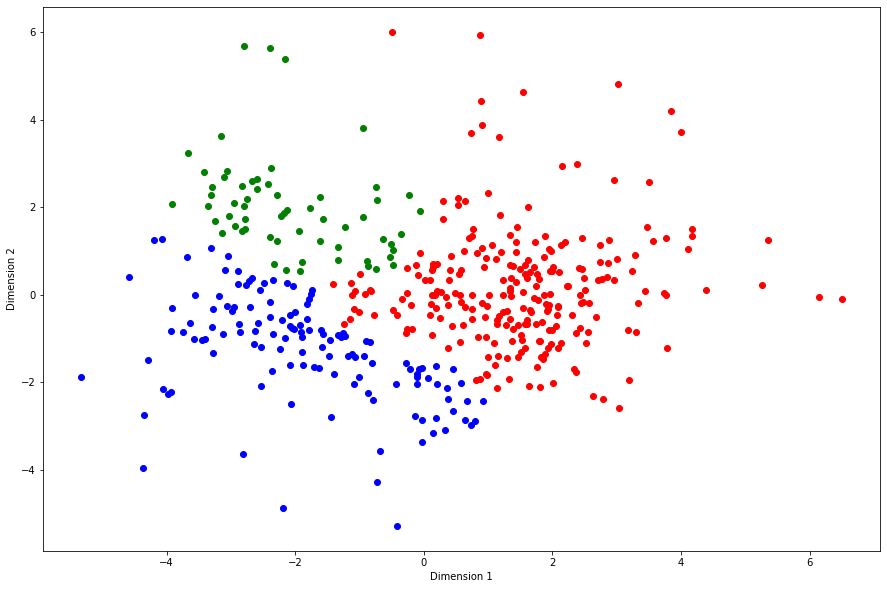

In [93]:
print('                  Agglomerative  Clustering       ')
reduced_data["label"] = y_hc
plt.figure(figsize = (15, 10))
plt.scatter(reduced_data["Dimension 1"][reduced_data.label == 0], reduced_data["Dimension 2"][reduced_data.label == 0], color = "red")
plt.scatter(reduced_data["Dimension 1"][reduced_data.label == 1], reduced_data["Dimension 2"][reduced_data.label == 1], color = "blue")
plt.scatter(reduced_data["Dimension 1"][reduced_data.label == 2], reduced_data["Dimension 2"][reduced_data.label == 2], color = "green")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 2
Sample point 2 predicted to be in Cluster 2


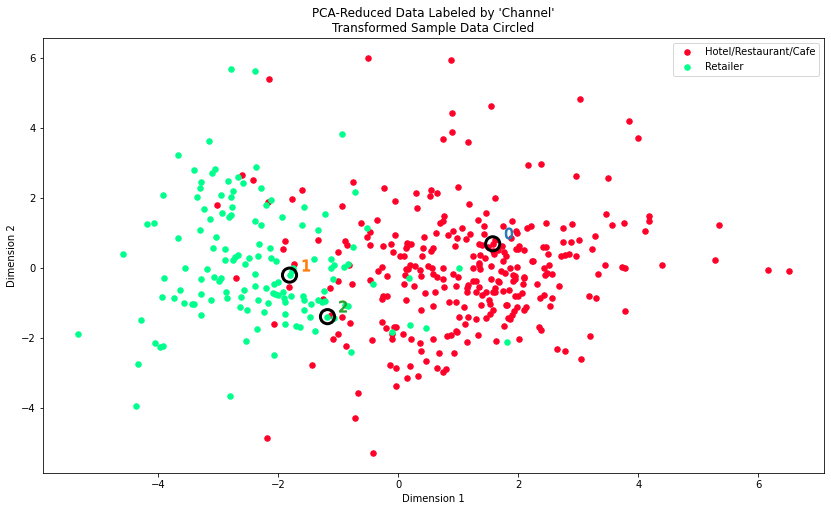

In [91]:
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)
    # Display the clustering results based on 'Channel' data
channel_results(reduced_data, outliers, pca_samples)